In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the datasets
df_cleaned = pd.read_csv('Trees_Quantified.csv')
df_economic = pd.read_csv('Economic_census.csv')

# Print column names of df_cleaned to verify correct column names
print(df_cleaned.columns)

# Binary analysis features (replace with actual columns)
binary_analysis = ['root_stone', 'root_grate', 'root_other', 'trunk_wire',
                   'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

unique_species = df_cleaned['spc_common'].unique() 
species_columns = [col for col in df_cleaned.columns if col in unique_species]

# Features and Target
X = df_cleaned[['census tract', 'latitude', 'longitude', 'postcode', 'borough'] + species_columns
               + binary_analysis + ['curb_loc', 'sidewalk', 'guards', 'steward', 'user_type', 'health']]
y = df_cleaned['health']  # Not used, just so we can split into train and test, y is actually economic % that is used as w

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# StandardScaler
scaler = StandardScaler()

# Scale only the numerical features (exclude categorical ones like 'borough' and 'census tract')
numerical_cols = ['curb_loc', 'sidewalk', 'guards', 'steward', 'health'] + binary_analysis

# Apply StandardScaler on numerical columns of X_train and X_test
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Combine X_train, y_train into a single dataframe

df_economic['Poverty Percent'] =  scaler.fit_transform(df_economic[['Poverty Percent']])
print(len(df_economic['census tract'].unique()))

# Assuming 'df_economic' has columns 'Council District' and 'Borough' to match with df_cleaned
# Merge based on 'census tract' and 'borough' columns in both dataframes
df_combined = df_economic.merge(X_train, on=['census tract', 'borough'], how='inner')

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       ...
       'bigtooth aspen', 'trident maple', 'Virginia pine', 'pagoda dogwood',
       'Japanese hornbeam', 'pine', 'two-winged silverbell', 'false cypress',
       'pitch pine', 'mimosa.1'],
      dtype='object', length=180)
1319


In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Make dataset for test
df_combined_test = df_economic.merge(X_test, on=['census tract', 'borough'], how='inner')
df_KNN_test = df_combined_test.copy()
df_KNN_test = df_KNN_test.drop(columns=['census tract', 'borough'])
w_test= df_KNN_test['Poverty Percent']
X_test_no_borough = df_KNN_test.iloc[:, df_KNN_test.columns != 'Poverty Percent']

df_KNN = df_combined.copy()
df_KNN = df_KNN.drop(columns=['census tract', 'borough'])
w_train= df_KNN['Poverty Percent']
X_train_no_borough = df_KNN.iloc[:, df_KNN.columns != 'Poverty Percent']

#knn train
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train_no_borough, w_train)

#KNN test
w_pred_no_loc = knn.predict(X_test_no_borough)
mse_no_loc = mean_squared_error(w_test, w_pred_no_loc)
r2_no_loc = r2_score(w_test, w_pred_no_loc)
print("Mean Squared Error (Test Set):", mse_no_loc)
print("R^2 Score (Test Set):", r2_no_loc)

Mean Squared Error (Test Set): 0.1996047921432245
R^2 Score (Test Set): 0.7526004388767418


In [3]:
# Function to modify the census tract based on its length
df_combined_test['census tract'] = df_combined_test['census tract'].astype(str).str.replace('.00', '', regex=True)
def striging(census):
    modified_tracts = []
    for part in census:
        part1 = str(part)
        part_no = part1
        if part1[len(part1)-2]=='.':
            part_no = part_no[:len(part1)-2]
        modified_tracts.append(part_no)
    return modified_tracts

df_combined_test['census tract'] = striging(df_combined_test['census tract'])
print(df_combined_test['census tract'])

0           2
1           2
2           2
3           2
4           2
         ... 
199246    323
199247    323
199248    323
199249    323
199250    323
Name: census tract, Length: 199251, dtype: object


In [4]:
import numpy as np
w_pred_no_loc = np.round(w_pred_no_loc, decimals =2)
df_predictions = pd.DataFrame({'predicted_poverty': w_pred_no_loc})

# Concatenate the predictions with the original DataFrame
df_final = pd.concat([df_combined_test, df_predictions], axis=1)
# Save the new DataFrame with predictions to a CSV file
df_final['census tract'] = df_final['census tract'].astype(str)
df_final.to_csv('Combined_Prediction.csv', index=False)

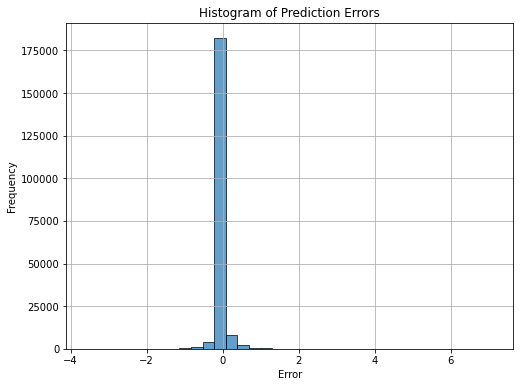

In [13]:
# Compute the error (difference between true and predicted values)
import matplotlib.pyplot as plt
errors = w_test - w_pred_no_loc

# Plot a histogram of the errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=35, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Make dataset for test
df_combined_test = df_economic.merge(X_test, on=['census tract', 'borough'], how='inner')
df_KNN_test = df_combined_test.copy()
df_KNN_test = df_KNN_test.drop(columns=['census tract', 'borough'])
w_test= df_KNN_test['Poverty Percent']
X_test_no_borough = df_KNN_test.iloc[:, df_KNN_test.columns != 'Poverty Percent']

df_KNN = df_combined.copy()
df_KNN = df_KNN.drop(columns=['census tract', 'borough'])
w_train= df_KNN['Poverty Percent']
X_train_no_borough = df_KNN.iloc[:, df_KNN.columns != 'Poverty Percent']

#knn train
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_no_borough, w_train)

#KNN test
w_pred_no_loc = knn.predict(X_test_no_borough)
mse_no_loc = mean_squared_error(w_test, w_pred_no_loc)
r2_no_loc = r2_score(w_test, w_pred_no_loc)
print("Mean Squared Error (Test Set):", mse_no_loc)
print("R^2 Score (Test Set):", r2_no_loc)

Mean Squared Error (Test Set): 0.20258613072041753
R^2 Score (Test Set): 0.74890522771654


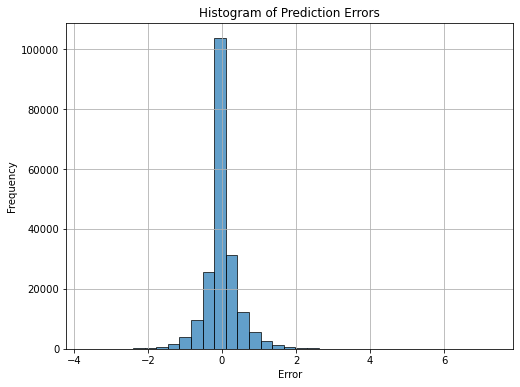

In [15]:
# Compute the error (difference between true and predicted values)
import matplotlib.pyplot as plt
errors = w_test - w_pred_no_loc

# Plot a histogram of the errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=35, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
from scipy.stats import kurtosis
kurtosis_actual = kurtosis(w_test)
kurtosis_pred = kurtosis(w_pred_no_loc)
print("Kurtosis of Actual Values (w_test):", kurtosis_actual)
print("Kurtosis of Predicted Values (w_pred_no_loc):", kurtosis_pred)

Kurtosis of Actual Values (w_test): 0.9667273085037635
Kurtosis of Predicted Values (w_pred_no_loc): 0.7297757876252269


In [17]:
import numpy as np
w_pred_no_loc = np.round(w_pred_no_loc, decimals =2)
df_predictions = pd.DataFrame({'predicted_poverty': w_pred_no_loc})

# Concatenate the predictions with the original DataFrame
df_final = pd.concat([df_combined_test, df_predictions], axis=1)
# Save the new DataFrame with predictions to a CSV file
df_final['census tract'] = df_final['census tract'].astype(str)
df_final.to_csv('Combined_Prediction.csv', index=False)

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

#knn train
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_no_borough, w_train)

#KNN test
w_pred_no_loc = knn.predict(X_test_no_borough)
mse_no_loc = mean_squared_error(w_test, w_pred_no_loc)
r2_no_loc = r2_score(w_test, w_pred_no_loc)
print("Mean Squared Error (Test Set):", mse_no_loc)
print("R^2 Score (Test Set):", r2_no_loc)

Mean Squared Error (Test Set): 0.19744177223937157
R^2 Score (Test Set): 0.7552813874109338


In [19]:
from scipy.stats import kurtosis
kurtosis_actual = kurtosis(w_test)
kurtosis_pred = kurtosis(w_pred_no_loc)
print("Kurtosis of Actual Values (w_test):", kurtosis_actual)
print("Kurtosis of Predicted Values (w_pred_no_loc):", kurtosis_pred)

Kurtosis of Actual Values (w_test): 0.9667273085037635
Kurtosis of Predicted Values (w_pred_no_loc): 0.7788317097887791


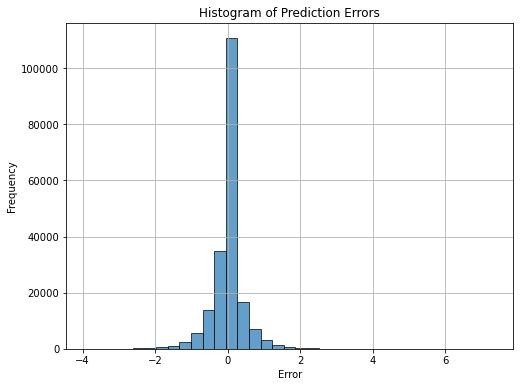

In [20]:
import matplotlib.pyplot as plt
errors = w_test - w_pred_no_loc

# Plot a histogram of the errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=35, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [21]:
#knn train
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train_no_borough, w_train)

#KNN test
w_pred_no_loc = knn.predict(X_test_no_borough)
mse_no_loc = mean_squared_error(w_test, w_pred_no_loc)
r2_no_loc = r2_score(w_test, w_pred_no_loc)
print("Mean Squared Error (Test Set):", mse_no_loc)
print("R^2 Score (Test Set):", r2_no_loc)

Mean Squared Error (Test Set): 0.1996047921432245
R^2 Score (Test Set): 0.7526004388767418


In [22]:
from scipy.stats import kurtosis
kurtosis_actual = kurtosis(w_test)
kurtosis_pred = kurtosis(w_pred_no_loc)
print("Kurtosis of Actual Values (w_test):", kurtosis_actual)
print("Kurtosis of Predicted Values (w_pred_no_loc):", kurtosis_pred)

Kurtosis of Actual Values (w_test): 0.9667273085037635
Kurtosis of Predicted Values (w_pred_no_loc): 0.8418325968138842


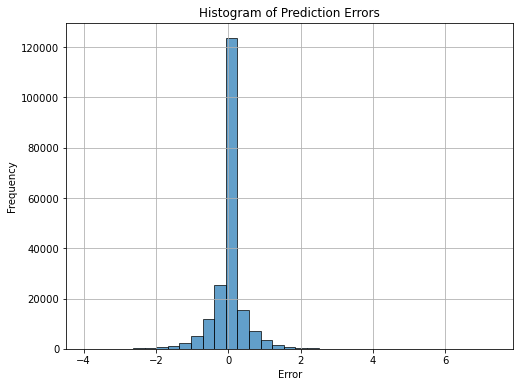

In [23]:
import matplotlib.pyplot as plt
errors = w_test - w_pred_no_loc

# Plot a histogram of the errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=35, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [24]:
#knn train
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_no_borough, w_train)

#KNN test
w_pred_no_loc = knn.predict(X_test_no_borough)
mse_no_loc = mean_squared_error(w_test, w_pred_no_loc)
r2_no_loc = r2_score(w_test, w_pred_no_loc)
print("Mean Squared Error (Test Set):", mse_no_loc)
print("R^2 Score (Test Set):", r2_no_loc)

Mean Squared Error (Test Set): 0.2182717761596536
R^2 Score (Test Set): 0.7294637015090051
